# JAXBird Performance Benchmarking

This notebook benchmarks PyBird performance across different backends:
- **Standard PyBird** (NumPy backend)
- **JAXBird** (JAX backend, full computation)  
- **JAXBird + Emulator** (JAX backend with neural network emulator)
- **Vectorized JAXBird + Emulator** (Batch processing multiple cosmologies)

## Setup


In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
jax.config.update("jax_enable_x64", True)

# Standard imports
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from timeit import timeit
from scipy.interpolate import interp1d
from jax import grad, jit, vmap
from pybird.symbolic import Symbolic 
# Set random seeds for reproducibility
np.random.seed(1)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)


# PyBird imports
import pybird.config as config
from pybird.correlator import Correlator

print(f"JAX Backend: {jax.default_backend()}")
print(f"JAX Devices: {jax.devices()}")


JAX Backend: cpu
JAX Devices: [CpuDevice(id=0)]


## **Cosmology Setup**


Setting up simple cosmology without external data dependencies. Lets use our internal `Symbolic` emulator for this 


In [2]:
z = 0.57
k_r, k_l = 0.7, 1e-4
kk = np.logspace(np.log10(k_l), np.log10(k_r), 500)

# Use simple k-array for output 
kmax = 0.4

# Cosmological parameters 
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}

# Initialize Symbolic cosmology class
S = Symbolic()
S.set(cosmo)
S.compute(kk, z)

# Extract power spectrum and cosmological parameters
pk_lin = S.pk_lin  # Linear power spectrum at redshift z
D1, f1 = S.D, S.f  # Growth factor and growth rate


eft_params = {
    'b1': 1.95, 'b2': 0.41, 'b3': -0.36, 'b4': 0.41,
    'cct': 0.18, 'cr1': -0.84, 'cr2': -0.81,
    'ce0': 1.50, 'ce1': 0.0, 'ce2': -1.63
}
print("EFT Parameters:", {k: f"{v:.3f}" for k, v in eft_params.items()})


EFT Parameters: {'b1': '1.950', 'b2': '0.410', 'b3': '-0.360', 'b4': '0.410', 'cct': '0.180', 'cr1': '-0.840', 'cr2': '-0.810', 'ce0': '1.500', 'ce1': '0.000', 'ce2': '-1.630'}


## Benchmark 1: Standard PyBird (NumPy)


In [3]:
# Disable JAX for standard PyBird
config.set_jax_enabled(False)

# Setup standard PyBird correlator - simplified without survey masks or AP
N_bird = Correlator()
N_bird.set({
    'output': 'bPk', 'multipole': 3,
    'kmax': kmax, 'with_resum': True, 
    'with_exact_time': True, 'with_time': False,
    'km': 0.7, 'kr': 0.25, 'nd': 3e-4,
    'eft_basis': 'eftoflss', 'with_stoch': True, 
    'fftaccboost':2,
})

kd = N_bird.co.k #internal knots used by PyBird

def compute_standard_pk(pk_lin_variation):
    """Compute power spectrum with standard PyBird (no AP or survey mask)"""
    N_bird.compute({
        'kk': kk, 'pk_lin': pk_lin_variation, 'D': D1, 'f': f1, 'z': z})
    return N_bird.get(eft_params)

# Warmup run
print("Initializing Standard PyBird...")
bpk_reference = compute_standard_pk(pk_lin)

# Benchmark timing
print("Benchmarking Standard PyBird...")
num_runs = 20
std_time = timeit(lambda: compute_standard_pk(pk_lin), number=num_runs)
avg_time = std_time / num_runs

print(f"Standard PyBird: {avg_time:.3f} seconds per evaluation")
print(f"Output shape: {bpk_reference.shape}")

# Store timing for comparison
benchmark_times = {'Standard PyBird': avg_time}


Initializing Standard PyBird...
Benchmarking Standard PyBird...
Standard PyBird: 0.329 seconds per evaluation
Output shape: (3, 77)


## Benchmark 2: JAXBird (JAX without emulator)


In [4]:
config.set_jax_enabled(True)

pk_lin_jax = jnp.array(pk_lin)
kk_jax = jnp.array(kk)

# Setup JAXBird correlator - simplified without survey masks or AP
N_jax = Correlator()
N_jax.set({
    'output': 'bPk', 'multipole': 3,
    'kmax': kmax, 'with_resum': True,
    'with_exact_time': True, 'with_time': False,
    'km': 0.7, 'kr': 0.25, 'nd': 3e-4,
    'eft_basis': 'eftoflss', 'with_stoch': True,
    'fftaccboost':2,
})

def compute_jax_pk(pk_lin_variation):
    N_jax.compute({
        'kk': kk_jax, 'pk_lin': pk_lin_variation, 'D': D1, 'f': f1, 'z': z})
    return N_jax.get(eft_params)

# JIT compile
jit_compute_jax_pk = jit(compute_jax_pk)

# Warmup compilation
print("Compiling JAXBird...")
bpk_jax = jit_compute_jax_pk(pk_lin_jax)

# Benchmark timing
print("Benchmarking JAXBird...")
num_runs = 200
jax_time = timeit(lambda: jit_compute_jax_pk(pk_lin_jax), number=num_runs)
avg_time = jax_time / num_runs

print(f"JAXBird: {avg_time:.3f} seconds per evaluation")
speedup = benchmark_times['Standard PyBird'] / avg_time
print(f"Speedup: {speedup:.1f}x faster than Standard PyBird")

# Store timing
benchmark_times['JAXBird'] = avg_time


jax: on
Compiling JAXBird...
Benchmarking JAXBird...
JAXBird: 0.080 seconds per evaluation
Speedup: 4.1x faster than Standard PyBird


## Benchmark 3: JAXBird + Emulator


In [5]:
# Setup JAXBird with emulator - simplified without survey masks or AP
N_emu = Correlator()
N_emu.set({
    'output': 'bPk', 'multipole': 3,
    'kmax': kmax, 'with_resum': True,
    'with_exact_time': True, 'with_time': False,
    'km': 0.7, 'kr': 0.25, 'nd': 3e-4,
    'with_emu': True,  # Enable emulator
    'eft_basis': 'eftoflss', 'with_stoch': True, 
    'fftaccboost':2,
})

def compute_emu_pk(pk_lin_variation):
    """Compute power spectrum with JAXBird + Emulator (no AP or survey mask)"""
    N_emu.compute({
        'kk': kk_jax, 'pk_lin': pk_lin_variation, 'D': D1, 'f': f1, 'z': z})
    return N_emu.get(eft_params)

# JIT compile
jit_compute_emu_pk = jit(compute_emu_pk)

# Warmup compilation
print("Compiling JAXBird + Emulator...")
bpk_emu = jit_compute_emu_pk(pk_lin_jax)

# Benchmark timing
print("Benchmarking JAXBird + Emulator...")
num_runs = 500
emu_time = timeit(lambda: jit_compute_emu_pk(pk_lin_jax), number=num_runs)
avg_time = emu_time / num_runs

print(f"JAXBird + Emulator: {avg_time:.4f} seconds per evaluation")
speedup = benchmark_times['Standard PyBird'] / avg_time
print(f"Speedup: {speedup:.1f}x faster than Standard PyBird")

# Store timing
benchmark_times['JAXBird + Emulator'] = avg_time


Compiling JAXBird + Emulator...
Benchmarking JAXBird + Emulator...
JAXBird + Emulator: 0.0005 seconds per evaluation
Speedup: 685.7x faster than Standard PyBird


## Benchmark 4: Vectorized JAXBird + Emulator (Batch Processing)


In [6]:
# Vectorized JAXBird + Emulator for batch processing multiple cosmologies
# This demonstrates the massive speedup when evaluating many cosmologies simultaneously

# Create vectorized version using vmap
vmap_compute_emu_pk = jit(vmap(compute_emu_pk, in_axes=0))

# Test with batch of cosmologies
batch_size = 256
print(f"Creating batch of {batch_size} different cosmologies...")

# Generate batch of slightly different power spectra (simulating different cosmologies)
pk_batch = jnp.array([pk_lin_jax * (1 + 0.05*np.random.randn()) for _ in range(batch_size)])

# Warmup compilation for vectorized version
print("Compiling Vectorized JAXBird + Emulator...")
bpk_batch = vmap_compute_emu_pk(pk_batch)

# Benchmark vectorized processing
print("Benchmarking Vectorized JAXBird + Emulator...")
num_runs = 200
batch_time = timeit(lambda: vmap_compute_emu_pk(pk_batch * (1 + 0.01*jnp.array(np.random.randn(batch_size, 1)))), number=num_runs)
avg_batch_time = batch_time / num_runs
avg_per_cosmology = avg_batch_time / batch_size

print(f"Vectorized JAXBird + Emulator: {avg_batch_time:.4f} seconds for {batch_size} cosmologies")
print(f"Per cosmology: {avg_per_cosmology:.5f} seconds per evaluation")

speedup = benchmark_times['Standard PyBird'] / avg_per_cosmology
print(f"Speedup: {speedup:.0f}x faster than Standard PyBird")

# Compare efficiency
efficiency = batch_size * benchmark_times['JAXBird + Emulator'] / avg_batch_time
print(f"Vectorization efficiency: {efficiency:.1f}x (ideal would be {batch_size}x)")

# Store timing
benchmark_times['Vectorized JAXBird + Emulator'] = avg_per_cosmology


Creating batch of 256 different cosmologies...
Compiling Vectorized JAXBird + Emulator...
Benchmarking Vectorized JAXBird + Emulator...
Vectorized JAXBird + Emulator: 0.0087 seconds for 256 cosmologies
Per cosmology: 0.00003 seconds per evaluation
Speedup: 9632x faster than Standard PyBird
Vectorization efficiency: 14.0x (ideal would be 256x)


## Performance Summary


PYBIRD PERFORMANCE BENCHMARK RESULTS
Standard PyBird               : 0.32906 seconds  (    1x speedup)
JAXBird                       : 0.08000 seconds  (    4x speedup)
JAXBird + Emulator            : 0.00048 seconds  (  686x speedup)
Vectorized JAXBird + Emulator : 0.00003 seconds  ( 9632x speedup)


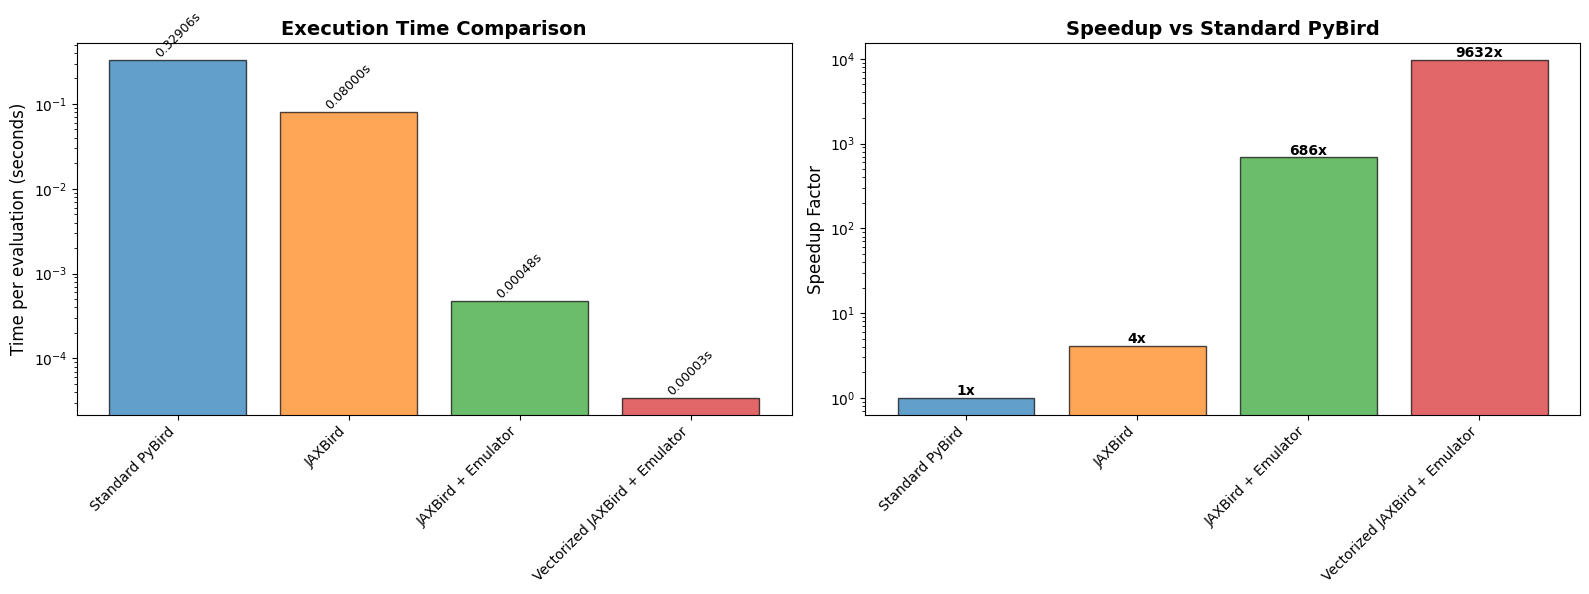

In [7]:
# Performance comparison and visualization
print("=" * 70)
print("PYBIRD PERFORMANCE BENCHMARK RESULTS")
print("=" * 70)

for method, time in benchmark_times.items():
    speedup = benchmark_times['Standard PyBird'] / time
    print(f"{method:30s}: {time:.5f} seconds  ({speedup:5.0f}x speedup)")

print("=" * 70)

# Create comprehensive performance comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Execution time (log scale)
methods = list(benchmark_times.keys())
times = list(benchmark_times.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars1 = ax1.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_ylabel('Time per evaluation (seconds)', fontsize=12)
ax1.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log')

# Add value labels on bars
for bar, time in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.5f}s', ha='center', va='bottom', fontsize=9, rotation=45)

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot 2: Speedup factors
speedups = [benchmark_times['Standard PyBird'] / time for time in times]
bars2 = ax2.bar(methods, speedups, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_ylabel('Speedup Factor', fontsize=12)
ax2.set_title('Speedup vs Standard PyBird', fontsize=14, fontweight='bold')
ax2.set_yscale('log')

# Add speedup labels
for bar, speedup in zip(bars2, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{speedup:.0f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()
